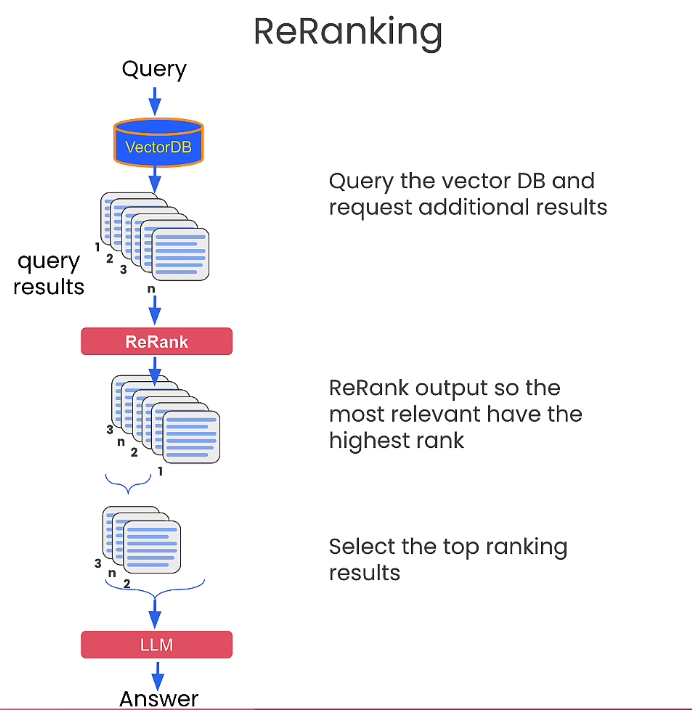

In [1]:
from helper_utils import load_chroma, word_wrap, project_embeddings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
import numpy as np

In [2]:
embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='microsoft_annual_report_2022.pdf', collection_name='microsoft_annual_report_2022', embedding_function=embedding_function)
chroma_collection.count()

2025-03-25 00:51:46.085564: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742842306.202492   77067 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742842306.235879   77067 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742842306.482567   77067 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742842306.482617   77067 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742842306.482620   77067 computation_placer.cc:177] computation placer alr

349

# Re-ranking the long tail

In [3]:
query = "What has been the investment in research and development?"
results = chroma_collection.query(query_texts=query, n_results=10, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

• operating expenses increased $ 1. 5 billion or 14 % driven by
investments in gaming, search and news advertising, and windows
marketing. operating expenses research and development ( in millions,
except percentages ) 2022 2021 percentage change research and
development $ 24, 512 $ 20, 716 18 % as a percent of revenue 12 % 12 %
0ppt research and development expenses include payroll, employee
benefits, stock - based compensation expense, and other headcount -
related expenses associated with product development. research and
development expenses also include third - party development and
programming costs, localization costs incurred to translate software
for international markets, and the amortization of purchased software
code and services content. research and development expenses increased
$ 3. 8 billion or 18 % driven by investments in cloud engineering,
gaming, and linkedin. sales and marketing ( in millions, except
percentages ) 2022 2021

competitive in local markets and enable

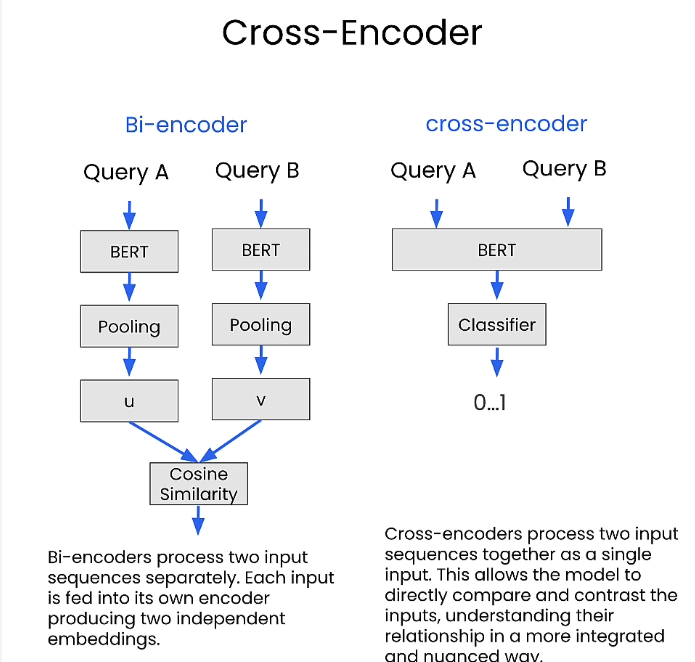

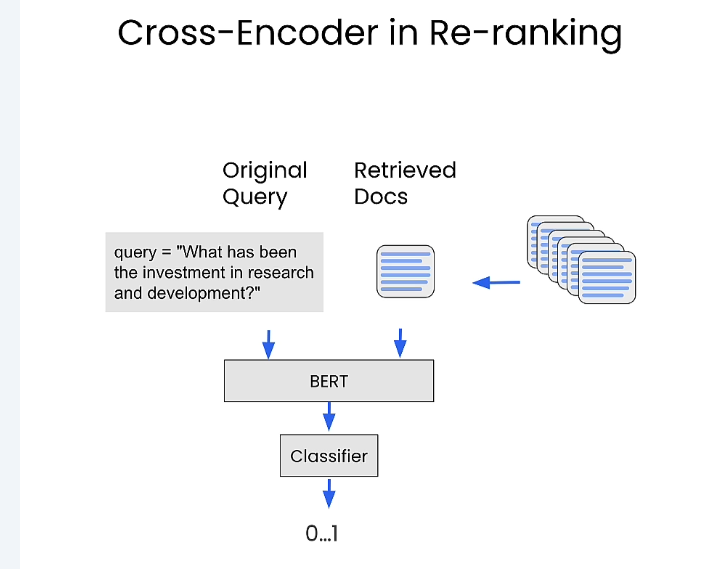

In [4]:
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [5]:
pairs = [[query, doc] for doc in retrieved_documents]
scores = cross_encoder.predict(pairs)
print("Scores:")
for score in scores:
    print(score)

Scores:
0.8762909
2.644577
-0.26802891
-10.73159
-7.706605
-5.6469994
-4.297037
-10.933233
-7.0384283
-7.324694


In [6]:
print("New Ordering:")
for o in np.argsort(scores)[::-1]:
    print(o+1)

New Ordering:
2
1
3
7
6
9
10
5
4
8


# Re-ranking with Query Expansion

In [ ]:
original_query = "What were the most important factors that contributed to increases in revenue?"
generated_queries = [
    "What was the overall revenue growth rate compared to the previous year?",
    "Which product or service segment drove the most revenue growth?",
    "Were there any significant changes in pricing or sales volume?",
    "Did the company make any strategic acquisitions or partnerships that impacted revenue?",
    "Were there any changes in the company's geographic sales mix that contributed to revenue growth?"
]

In [8]:
queries = [original_query] + generated_queries

results = chroma_collection.query(query_texts=queries, n_results=10, include=['documents', 'embeddings'])
retrieved_documents = results['documents']

In [9]:
# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

unique_documents = list(unique_documents)

In [10]:
pairs = []
for doc in unique_documents:
    pairs.append([original_query, doc])

In [11]:
scores = cross_encoder.predict(pairs)


In [12]:
print("Scores:")
for score in scores:
    print(score)

Scores:
-10.119464
-10.634941
-9.4284725
-3.7948651
-10.000139
-10.187725
-7.975194
-10.042843
-4.818485
-1.136996
-11.087107
-7.73989
-6.9020905
-8.505106
-9.768024
-5.1418324
-4.3417664
-3.7681546
-7.503584
-11.233841
-5.2747507
-7.445792
-10.017991
-4.651892


In [13]:
print("New Ordering:")
for o in np.argsort(scores)[::-1]:
    print(o)

New Ordering:
9
17
3
16
23
8
15
20
12
21
18
11
6
13
2
14
4
22
7
0
5
1
10
19
